# Logistic Regression
* Supervised learning türünde output etiketleri olan Y'nin 0 ya da 1 olması durumunda tercih edilen bir öğrenme algoritmasıdır. Yani Binary Classification olarak adlandırılan ikili sınıflandırma problemleri  için kullanılmaktadır.
* Kedileri tanımak için bir logistic regression sınıflandırıcısı oluşturdum. Bu sınıflandırıcı bana bir neural network zihniyetini nasıl oluşturacağım konusunda yol göstermektedir ve aynı zamanda deep learning hakkındaki sezgilerimi geliştirmem açısından yardımcı olmaktadır.


![alt text](Logistic_Regression.gif "Title")

### Packages

In [1]:
import numpy as np # fundemental package for scientific computing with Python
import matplotlib.pyplot as plt # famous library to plot graphs in Python
import h5py # common package to interact with a dataset that is stored on a H5 file
from lr_utils import load_dataset # dataset editing and parsing library

%matplotlib inline

### Overview of the Dataset


**Kullanmış olduğum dataset şunları içermektedir:**
* cat (y=1) ya da non-cat(y=0) olarak etiketlenmiş resimleri barındıran m_train adında bir eğitim seti
* cat ya da non-cat olarak etiketlenmiş resimleri barındıran m_test adında bir test seti

In [2]:
# Load the dataset (cat/non-cat)
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

y = [1], it's a 'cat' picture.


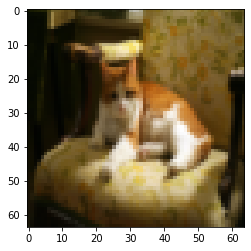

In [3]:
#Example of a picture
index = 7
plt.imshow(train_set_x_orig[index]);
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [4]:
m_train = train_set_x_orig.shape[0] # number of training examples
m_test = test_set_x_orig.shape[0]   # number of test examples
num_px = train_set_x_orig.shape[1]  # width of a trainin image

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
Each image is of size: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [5]:
# Reshape the training and test examples

train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0],-1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))


train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


**NOT:** Renkli görüntüleri temsil etmek için, her piksel için RGB(Red, Green, Blue) kanalları kullanılmaktadır. Bu nedenle piksel değerleri 0-255 arasında değişen üç sayıdan oluşan bir vektördür. Deep learning ve machine learning dünyasında yaygın bir ön işleme adımı, datasetimizi ortalamak ve standartlaştırmaktır. Resim datasetlerinde bu işlem oldukça basittir ve her satırı 255 sayısına bölmek hemen hemen işimizi görmektedir.

In [6]:
# Standardize dataset
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

### Building the algorithm


![alt text](model.PNG "Title")

**Neural network oluşturmak için kullanılan ana adımlar:**
 1. Model yapısının tanımlanması
 2. Oluşturulan modelin parametrelerinin initiliaze edilmesi
 3. Döngü(Loop): 
    * Güncel loss(kayıp) fonksiyonunun hesaplanması(forward propagation)
    * Güncel gradient fonksiyonunun hesaplanması(backward propagation)
    * Parametrelerin güncellenmesi(gradient descent)


In [7]:
# linear function (model helper function)
def sigmoid(z):
    """
    Compute the sigmoid of z

    Arguments:
    z -- A scalar or numpy array of any size.

    Return:
    s -- sigmoid(z)
    """
    s = 1. / (1 + np.exp(-z))
    
    return s

In [8]:
# test sigmoid function
sigmoid(5)

0.9933071490757153

In [9]:
# Initializing parameters 
def initialize_with_zeros(dim):
    """
    This function creates a vector of zeros of shape (dim, 1) for w and initializes b to 0.
    
    Argument:
    dim -- size of the w vector we want (or number of parameters in this case)
    
    Returns:
    w -- initialized vector of shape (dim, 1)
    b -- initialized scalar (corresponds to the bias)
    """
    
    w = np.zeros((dim, 1))
    b = 0
    
    assert(w.shape == (dim, 1))
    assert(isinstance(b, float) or isinstance(b, int))
    
    return w,b

In [10]:
# test initialize_with_zeros function
dim = 6
w, b = initialize_with_zeros(dim)
print ("w = " + str(w))
print ("b = " + str(b))

w = [[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]
b = 0


In [11]:
# Forward and Backward propagation 
def propagate(w, b, X, Y):
    """
    Implement the cost function and its gradient for the propagation explained above

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat) of size (1, number of examples)

    Return:
    cost -- negative log-likelihood cost for logistic regression
    dw -- gradient of the loss with respect to w, thus same shape as w
    db -- gradient of the loss with respect to b, thus same shape as b
    
    Tips:
    - Write your code step by step for the propagation. np.log(), np.dot()
    """
    m = X.shape[1]
    
    # FORWARD PROPAGATION (FROM X TO COST)
    z = np.dot(w.T, X) + b
    A = sigmoid(z)
    cost = -1/m*np.sum((Y*np.log(A))+((1-Y)*np.log(1-A)))
    
    # BACKWARD PROPAGATION (TO FIND GRAD)
    dw = 1/m*np.dot(X, (A-Y).T)
    db = 1/m*np.sum(A-Y)
    
    assert(dw.shape == w.shape)
    assert(db.dtype == float)
    cost = np.squeeze(cost)
    assert(cost.shape == ())
    
    grads = {"dw": dw,
             "db": db}
    
    return grads, cost

In [12]:
# Optimize function
def optimize(w, b, X, Y, num_iterations, learning_rate, print_cost = False):
    """
    This function optimizes w and b by running a gradient descent algorithm
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat), of shape (1, number of examples)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- True to print the loss every 100 steps
    
    Returns:
    params -- dictionary containing the weights w and bias b
    grads -- dictionary containing the gradients of the weights and bias with respect to the cost function
    costs -- list of all the costs computed during the optimization, this will be used to plot the learning curve.
    
    Tips:
    You basically need to write down two steps and iterate through them:
        1) Calculate the cost and the gradient for the current parameters. Use propagate().
        2) Update the parameters using gradient descent rule for w and b.
    """
    
    costs = []
    
    for i in range(num_iterations):
        
        
        # Cost and gradient calculation 
        grads, cost = propagate(w, b, X, Y)
        
        # Retrieve derivatives from grads
        dw = grads["dw"]
        db = grads["db"]
        
        # update rule 
        w = w-learning_rate*dw
        b = b-learning_rate*db
        
        # Record the costs
        if i % 100 == 0:
            costs.append(cost)
        
        # Print the cost every 100 training iterations
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
    
    params = {"w": w,
              "b": b}
    
    grads = {"dw": dw,
             "db": db}
    
    return params, grads, costs

In [13]:
# predict the model
def predict(w, b, X):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)
    
    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)
    
    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    
    m = X.shape[1]
    Y_prediction = np.zeros((1,m))
    w = w.reshape(X.shape[0], 1)
    
    # Compute vector "A" predicting the probabilities of a cat being present in the picture
    A = sigmoid(np.dot(w.T, X)+b)
    
    for i in range(A.shape[1]):
        
        # Convert probabilities A[0,i] to actual predictions p[0,i]
        Y_prediction[0, i] = 1 if A[0, i] > 0.5 else 0
    
    assert(Y_prediction.shape == (1, m))
    
    return Y_prediction

In [14]:
# create the model (functions implemented in the previous parts)
def model(X_train, Y_train, X_test, Y_test, num_iterations = 2000, learning_rate = 0.5, print_cost = False):
    """
    Builds the logistic regression model by calling the function you've implemented previously
    
    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to true to print the cost every 100 iterations
    
    Returns:
    d -- dictionary containing information about the model.
    """
    
    
    # initialize parameters with zeros (≈ 1 line of code)
    w, b = initialize_with_zeros(X_train.shape[0])

    # Gradient descent (≈ 1 line of code)
    parameters, grads, costs = optimize(w, b, X_train, Y_train, num_iterations, learning_rate, print_cost)
    
    # Retrieve parameters w and b from dictionary "parameters"
    w = parameters["w"]
    b = parameters["b"]
    
    # Predict test/train set examples (≈ 2 lines of code)
    Y_prediction_test = predict(w,b,X_test)
    Y_prediction_train = predict(w,b,X_train)


    # Print train/test Errors
    print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
    print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))

    
    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test, 
         "Y_prediction_train" : Y_prediction_train, 
         "w" : w, 
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}
    
    return d

In [15]:
# Run to train the model
d = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 2000, learning_rate = 0.005, print_cost = True)

Cost after iteration 0: 0.693147
Cost after iteration 100: 0.584508
Cost after iteration 200: 0.466949
Cost after iteration 300: 0.376007
Cost after iteration 400: 0.331463
Cost after iteration 500: 0.303273
Cost after iteration 600: 0.279880
Cost after iteration 700: 0.260042
Cost after iteration 800: 0.242941
Cost after iteration 900: 0.228004
Cost after iteration 1000: 0.214820
Cost after iteration 1100: 0.203078
Cost after iteration 1200: 0.192544
Cost after iteration 1300: 0.183033
Cost after iteration 1400: 0.174399
Cost after iteration 1500: 0.166521
Cost after iteration 1600: 0.159305
Cost after iteration 1700: 0.152667
Cost after iteration 1800: 0.146542
Cost after iteration 1900: 0.140872
train accuracy: 99.04306220095694 %
test accuracy: 70.0 %


**NOT:** Modelimiz neredeyse %100'e yakın yüksek bir oranla eğitilmiş fakat test accuracy %70 olarak sonuçlanmıştır. Bu aradaki fark modelimizin overfitting yani aşırı öğrenmiş bir model olduğunu ve test aşamasındaki verilerimizi iyi tanımamış olmasını göstermektedir. Bu problemi daha sonra çeşitli yöntemler kullanarak çözüp bu notebook'u güncelleyeceğim. Overfitting problemlerine karşı kullanılan bazı yöntemler L2, Dropout, Data Augmentation, Early Stopping'dir. Bunlara genel olarak regularization denmektedir. Amaç; test ve train accuracy arasındaki farkı minimuma indirmek ve modelimizi aşırı öğrenmeden engellemektr. 

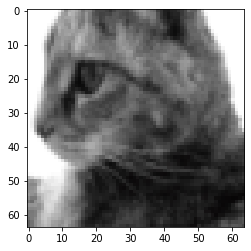

In [16]:
# Example of a picture that was wrongly classified.
index = 23
plt.imshow(test_set_x[:,index].reshape((num_px, num_px, 3)));

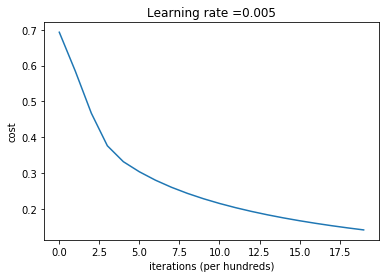

In [17]:
# Plot learning curve (with costs)
costs = np.squeeze(d['costs'])
plt.plot(costs)
plt.ylabel('cost')
plt.xlabel('iterations (per hundreds)')
plt.title("Learning rate =" + str(d["learning_rate"]))
plt.show()

learning rate is: 0.01
train accuracy: 99.52153110047847 %
test accuracy: 68.0 %

-------------------------------------------------------

learning rate is: 0.001
train accuracy: 88.99521531100478 %
test accuracy: 64.0 %

-------------------------------------------------------

learning rate is: 0.0001
train accuracy: 68.42105263157895 %
test accuracy: 36.0 %

-------------------------------------------------------



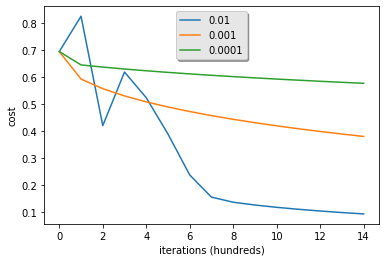

In [18]:
# Compare the learning curve of the model with several choices of learning rate
learning_rates = [0.01, 0.001, 0.0001]
models = {}
for i in learning_rates:
    print ("learning rate is: " + str(i))
    models[str(i)] = model(train_set_x, train_set_y, test_set_x, test_set_y, num_iterations = 1500, learning_rate = i, print_cost = False)
    print ('\n' + "-------------------------------------------------------" + '\n')

for i in learning_rates:
    plt.plot(np.squeeze(models[str(i)]["costs"]), label= str(models[str(i)]["learning_rate"]))

plt.ylabel('cost')
plt.xlabel('iterations (hundreds)')

legend = plt.legend(loc='upper center', shadow=True)
frame = legend.get_frame()
frame.set_facecolor('0.90')
plt.show()

* Bu çalışma eğitim platformu Coursera'da yer alan "Neural Networks and Deep Learning" kursundan destek alınarak yapılmıştır. 